<a href="https://colab.research.google.com/github/Juanezm/ml-model-battery-levels-iot/blob/main/scenario_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output
from IPython.display import HTML
from sklearn.model_selection import train_test_split


def normalise_data(scaler_x, x, scaler_y, y):
  X_train = pd.DataFrame(scaler_x.fit_transform(x))
  y_train = pd.DataFrame(scaler_y.fit_transform(y.values.reshape(-1, 1)))
  return X_train, y_train

def create_sequences(X, y, seq_length):
    xs = []
    ys = []

    for i in range(len(X)-seq_length):
        xs.append(X[i:(i+seq_length)])
        ys.append(y[i+seq_length])

    return np.array(xs), np.array(ys)


class PlotLearning(Callback):
    """
    Callback to plot the metrics during training.
    """
    def on_train_begin(self, logs={}):
        self.train_mean_absolute_error = []
        self.train_loss = []
        self.val_mean_absolute_error = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_mean_absolute_error.append(logs.get('mean_absolute_error'))
        self.train_loss.append(logs.get('loss'))
        self.val_mean_absolute_error.append(logs.get('val_mean_absolute_error'))
        self.val_loss.append(logs.get('val_loss'))

        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Graficar precisión
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), self.train_mean_absolute_error, 'o--', label='Training MAE')
        plt.plot(range(1, epoch + 2), self.val_mean_absolute_error, 'o--', label='Validation MAE')
        plt.xlabel('# epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid()

        # Graficar pérdida
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), self.train_loss, 'o--', label='Training MSE')
        plt.plot(range(1, epoch + 2), self.val_loss, 'o--', label='Validation MSE')
        plt.xlabel('# epochs')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()


def forecast_battery_consumption(test, seq_length, forecast_steps, future_steps, model, scaler_x, scaler_y):
    """
    This function is used to forecast battery consumption based on historical data.

    Parameters:
    test (pd.DataFrame): DataFrame that contains test data including 'Rain meter', 'Soil moisture', 'Battery' and 'date' columns.
    seq_length (int): Sequence length used for creating input sequences for the model.
    forecast_steps (int): Number of steps ahead to forecast.
    future_steps (int): Number of steps to shift for updating historical data.
    model (model): model used for prediction.
    scaler_x (scaler): Scaler used for scaling the features.
    scaler_y (scaler): Scaler used for scaling the target.

    Returns:
    matplotlib.pyplot: Plot of actual vs forecasted battery consumption.
    """

    historical_data = test[:seq_length+1]
    forecast_data = test[seq_length:seq_length+forecast_steps]
    weather_forecast = forecast_data.drop(columns=['Battery'])
    weather_forecast['Battery'] = np.nan
    updated_historical_data = historical_data

    for steps in range(0, forecast_steps, future_steps):

        # normalise historical_data
        X_hist, y_hist = normalise_data(
            scaler_x,
            updated_historical_data.drop(columns=['date']),
            scaler_y,
            updated_historical_data['Battery']
        )
        # create sequences out of historical_data
        X_hist_seq, y_hist_seq = create_sequences(X_hist.values, y_hist.values, seq_length)

        # predict next battery level
        next_battery_pred = model.predict(X_hist_seq)
        clear_output(wait=True)

        # inverse normalisation of predicted battery level
        next_battery_pred_inv = scaler_y.inverse_transform(next_battery_pred)[0][0]

        # Add predicted value to weather forecast
        weather_forecast.loc[weather_forecast.index[steps:steps+future_steps], 'Battery'] = next_battery_pred_inv

        # Update the historical data with the forecasted
        updated_historical_data = pd.concat([updated_historical_data[future_steps:], weather_forecast[steps:steps+future_steps]], ignore_index=True)


    # Plot actual vs predicted with dates
    plt.figure(figsize=(20, 6))

    plt.plot(pd.to_datetime(historical_data['date']), historical_data['Battery'], label='Historic')
    plt.plot(pd.to_datetime(weather_forecast['date']), weather_forecast['Battery'], label='Forecast', marker=".")
    plt.plot(pd.to_datetime(forecast_data['date']), forecast_data['Battery'], label='Real', marker=".")
    plt.title('Actual vs Forecasted Battery Consumption')
    plt.xlabel('Time')
    plt.ylabel('Battery Consumption')
    plt.legend()
    plt.grid()
    plt.show()

    print('RMSE: ', mean_squared_error(forecast_data['Battery'], weather_forecast['Battery'], squared=False))
    print('MSE:  ', mean_squared_error(forecast_data['Battery'], weather_forecast['Battery']))
    print('MAE:  ', mean_absolute_error(forecast_data['Battery'], weather_forecast['Battery']))

    return plt

def compare_model_performance(test, seq_length, future_steps, models, scaler_x, scaler_y):
    """
    This function is used to compare the performance of multiple models in terms of their ability to predict battery
    consumption based on historical data. It returns a list of dictionaries, each containing the minimum, maximum, mean,
    and standard deviation of the Mean Absolute Error (MAE) for each model.

    Parameters:
    test (pd.DataFrame): DataFrame that contains test data including 'Rain meter', 'Soil moisture', 'Battery' and 'date' columns.
    seq_length (int): Sequence length used for creating input sequences for the model.
    future_steps (int): Number of steps to shift for updating historical data.
    models (dict): Dictionary of models used for prediction, with model names as keys and models as values.
    scaler_x (scaler): Scaler used for scaling the features.
    scaler_y (scaler): Scaler used for scaling the target.

    Returns:
    list: A list of dictionaries. Each dictionary contains the model name as the key and the 'min', 'max', 'mean' and 'std' of
    the Mean Absolute Error (MAE) for the corresponding model as values.
    """

    num_intervals = len(test) // seq_length + 1
    metrics_list = {model_name: {'mae': [], 'date': [], 'stats': {}} for model_name, model in models}

    forecast_data_all = pd.DataFrame()

    for model_name, model in models:
      for i in range(num_intervals):
          historical_data = test[i*seq_length:(i+1)*seq_length+1]
          forecast_data = test[(i+1)*seq_length:((i+1)*seq_length)+future_steps]
          weather_forecast = forecast_data.drop(columns=['Battery'])
          weather_forecast['Battery'] = np.nan
          updated_historical_data = historical_data

          for steps in range(future_steps):
            if steps < len(weather_forecast):

              # normalise historical_data
              X_hist, y_hist = normalise_data(
                  scaler_x,
                  updated_historical_data.drop(columns=['date']),
                  scaler_y,
                  updated_historical_data['Battery']
              )
              # create sequences out of historical_data
              X_hist_seq, y_hist_seq = create_sequences(X_hist.values, y_hist.values, seq_length)

              # predict next battery level
              next_battery_pred = model.predict(X_hist_seq, verbose = 0)

              # inverse normalisation of predicted battery level
              next_battery_pred_inv = scaler_y.inverse_transform(next_battery_pred)[0][0]

              # Add predicted value to weather forecast
              weather_forecast.loc[weather_forecast.index[steps:steps+future_steps], 'Battery'] = next_battery_pred_inv

              # Update the historical data with the forecasted
              updated_historical_data = pd.concat([updated_historical_data[1:], weather_forecast.iloc[[steps]]], ignore_index=True)


          clear_output(wait=True)
          print(f'{i}/{num_intervals} intervals ===>  {steps}/{future_steps} steps')

          if not forecast_data.empty and not weather_forecast['Battery'].isnull().all():
              # Save metrics to list
              metrics_list[model_name]['mae'].append(mean_absolute_error(forecast_data['Battery'], weather_forecast['Battery']))
              metrics_list[model_name]['date'].append(pd.to_datetime(updated_historical_data['date'])[0])


    plt.figure(figsize=(20, 6))

    for model_name, metrics in metrics_list.items():
      plt.plot(metrics['date'], metrics['mae'], label=model_name)
      metrics['stats'] = {'min': np.min(metrics['mae']), 'max': np.max(metrics['mae']), 'mean': np.mean(metrics['mae']), 'std': np.std(metrics['mae'])}

    plt.title('MAE over Time intervals')
    plt.xlabel('Interval')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid()
    plt.show()

    return [{model_name: metrics['stats']} for model_name, metrics in metrics_list.items()]


# Load data
sensor_ids = [
    #'200034001951343334363036',
    '270043001951343334363036',
    #'380033001951343334363036',
    # '46004e000251353337353037',
    # '46005a000351353337353037',
    # '4e0022000251353337353037',
    # '4e0031000251353337353037',
]
train_datasets = [pd.read_csv(f'../src/data_cleaning/{id}_cleaned_data.csv') for id in sensor_ids]
print('Number of trainning sets: ', len(train_datasets))
test = pd.read_csv('../src/data_cleaning/200034001951343334363036_cleaned_data.csv')

# Convert the 'date' column to datetime
train_datasets = [train.assign(date = lambda x: pd.to_datetime(x['date'])) for train in train_datasets]
test['date'] = pd.to_datetime(test['date'])

# Set the 'date' column as the index
for train in train_datasets:
    train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

# Resample the DataFrame to 3-hour intervals, taking the mean of each interval
for i in range(len(train_datasets)):
    train_datasets[i] = train_datasets[i].resample('1H').mean().ffill()
test = test.resample('1H').mean().ffill()

# Reset the index to make 'date' a column again
for train in train_datasets:
    train.reset_index(inplace=True)
test.reset_index(inplace=True)

# Extract the hour from the 'date' column
for train in train_datasets:
    train['hour'] = train['date'].dt.hour
test['hour']  = test['date'].dt.hour

# Drop variables not available from Open Weather API forecast
for i in range(len(train_datasets)):
    train_datasets[i] = train_datasets[i].drop(columns=['Rain meter', 'Soil moisture'])
test = test.drop(columns=['Rain meter', 'Soil moisture'])

X_trains = []
y_trains = []
X_vals = []
y_vals = []

# Normalise Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

seq_length = 120

for train in train_datasets:
  # Split dataset in train and validation
  X_train, X_val, y_train, y_val = train_test_split(
      train.drop(columns=['date']),
      train['Battery'],
      test_size=0.2,
      shuffle=False
  )
  # Normalise train and validation datasets
  X_train_norm, y_train_norm = normalise_data(
      scaler_x, X_train,
      scaler_y, y_train
  )

  X_val_norm, y_val_norm = normalise_data(
      scaler_x, X_val,
      scaler_y, y_val
  )
  # Create sequences
  X_train_seq, y_train_seq = create_sequences(X_train_norm.values, y_train_norm.values, seq_length)
  X_val_seq, y_val_seq = create_sequences(X_val_norm.values, y_val_norm.values, seq_length)

  X_trains.append(X_train_seq)
  y_trains.append(y_train_seq)
  X_vals.append(X_val_seq)
  y_vals.append(y_val_seq)

# Normalise test dataset
X_test, y_test = normalise_data(
    scaler_x, test.drop(columns=['date']),
    scaler_y, test['Battery']
)
X_test_seq, y_test_seq =  create_sequences(X_test.values, y_test.values, seq_length)

print(f"Dimensiones de los datos de entrenamiento: {X_trains[0].shape}")
print(f"Dimensiones de los datos de validación: {X_vals[0].shape}")
print(f"Dimensiones de los datos de testeo: {X_test_seq.shape}")
print(f"Dimensiones de las etiquetas de entrenamiento: {y_trains[0].shape}")
print(f"Dimensiones de las etiquetas de validación: {y_vals[0].shape}")
print(f"Dimensiones de las etiquetas de testeo: {y_test_seq.shape}")

# Define model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_trains[0].shape[1], X_trains[0].shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
lstm_model.summary()

Number of trainning sets:  1
Dimensiones de los datos de entrenamiento: (2561, 120, 7)
Dimensiones de los datos de validación: (551, 120, 7)
Dimensiones de los datos de testeo: (3599, 120, 7)
Dimensiones de las etiquetas de entrenamiento: (2561, 1)
Dimensiones de las etiquetas de validación: (551, 1)
Dimensiones de las etiquetas de testeo: (3599, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11651 (45.51 KB)
Trainable params: 11651 (45.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


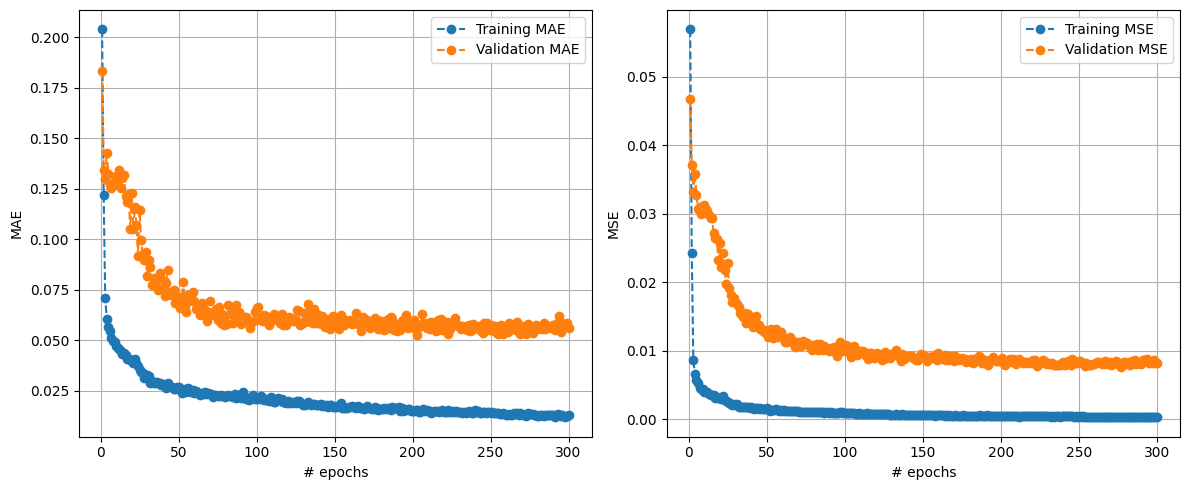

36/36 [==============================] - 3s 84ms/step - loss: 3.3053e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0082 - val_mean_absolute_error: 0.0560


In [2]:
for i in range(len(train_datasets)):
  lstm_model.fit(
      X_trains[i],
      y_trains[i],
      epochs=300,
      batch_size=72,
      validation_data=(X_vals[i], y_vals[i]),
      callbacks=[
          PlotLearning(),
          EarlyStopping(monitor='val_loss', patience=50)
      ]
  )

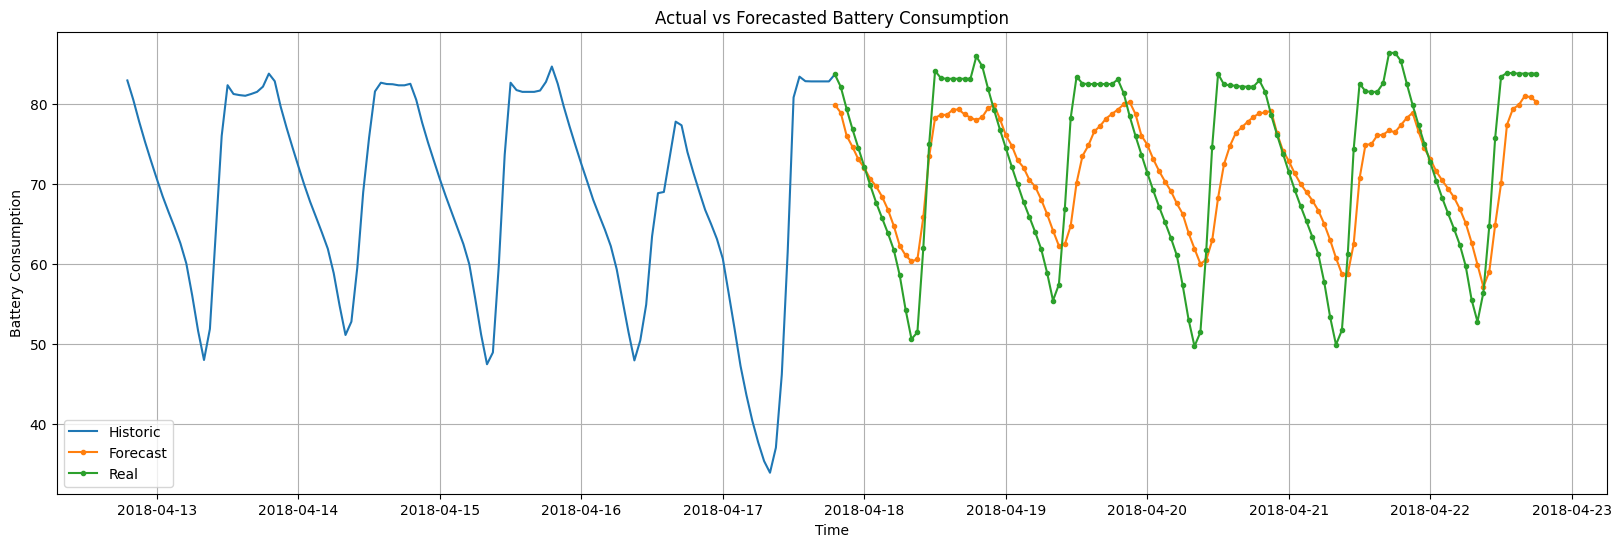

RMSE:  6.118289724926759
MSE:   37.43346915814436
MAE:   5.109490663740371


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [3]:
forecast_battery_consumption(test=test, seq_length=seq_length, forecast_steps=seq_length, future_steps=1, model=lstm_model, scaler_x=scaler_x, scaler_y=scaler_y)

In [4]:
# Define model
lstm_double_model = Sequential()
lstm_double_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_double_model.add(LSTM(50))
lstm_double_model.add(Dense(1, activation='sigmoid'))
lstm_double_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
lstm_double_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 120, 50)           11600     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31851 (124.42 KB)
Trainable params: 31851 (124.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


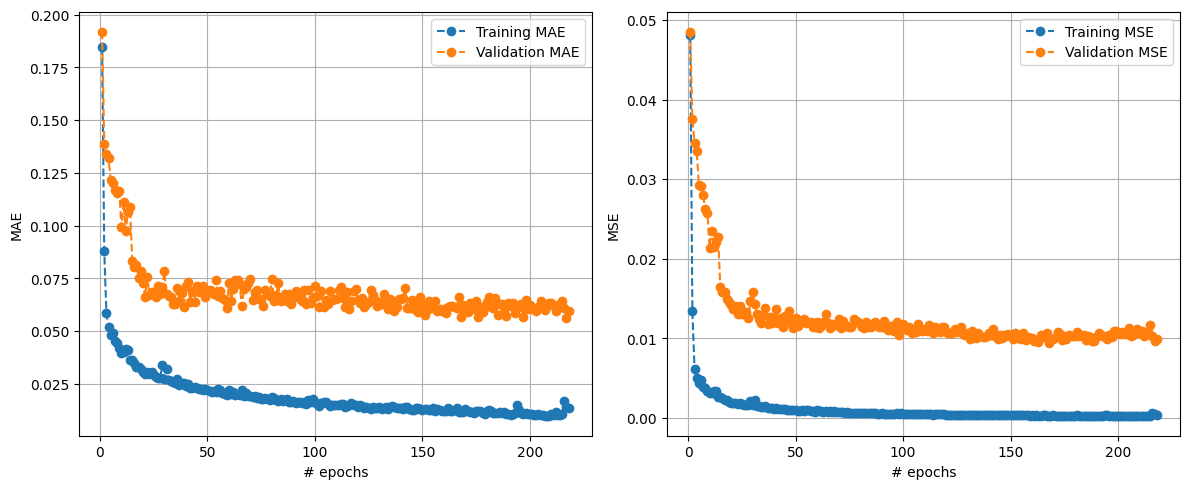

36/36 [==============================] - 7s 208ms/step - loss: 3.7684e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0099 - val_mean_absolute_error: 0.0596


In [5]:
for i in range(len(train_datasets)):
  lstm_double_model.fit(
      X_trains[i],
      y_trains[i],
      epochs=300,
      batch_size=72,
      validation_data=(X_vals[i], y_vals[i]),
      callbacks=[
          PlotLearning(),
          EarlyStopping(monitor='val_loss', patience=50)
      ]
  )

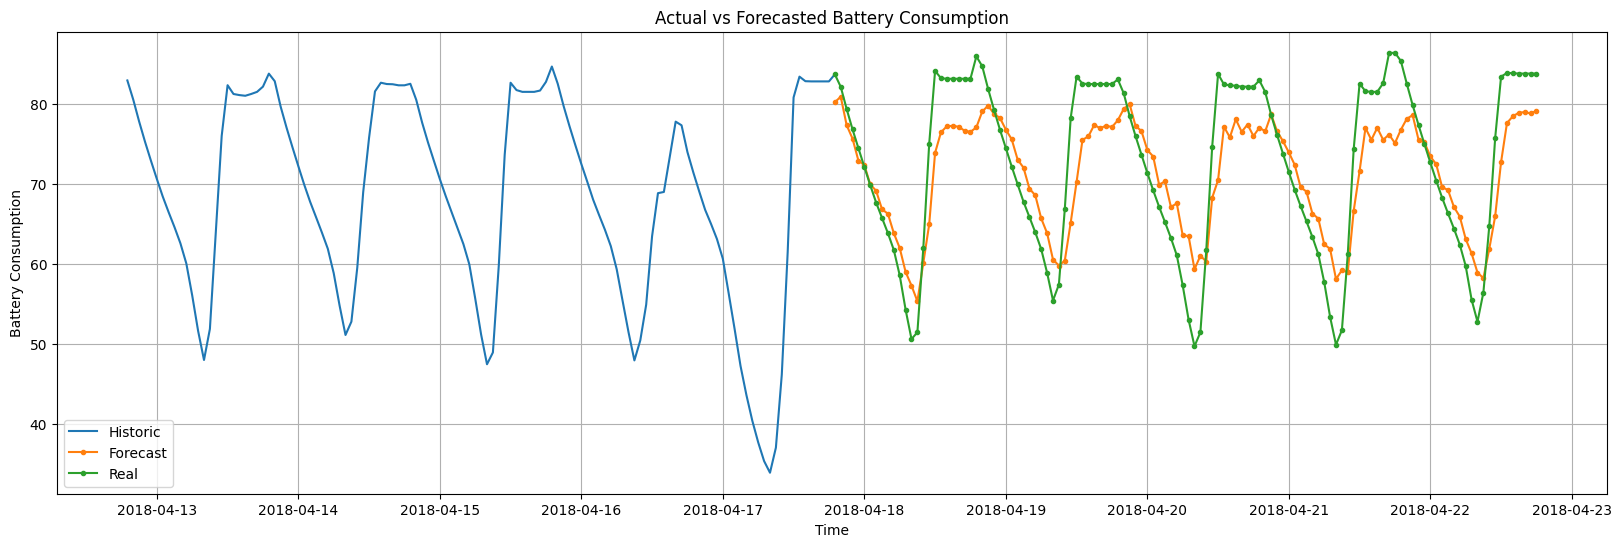

RMSE:  5.648035534162634
MSE:   31.90030539516379
MAE:   4.78591812854343


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [6]:
forecast_battery_consumption(test=test, seq_length=seq_length, forecast_steps=seq_length, future_steps=1, model=lstm_double_model, scaler_x=scaler_x, scaler_y=scaler_y)

30/31 intervals ===>  119/120 steps


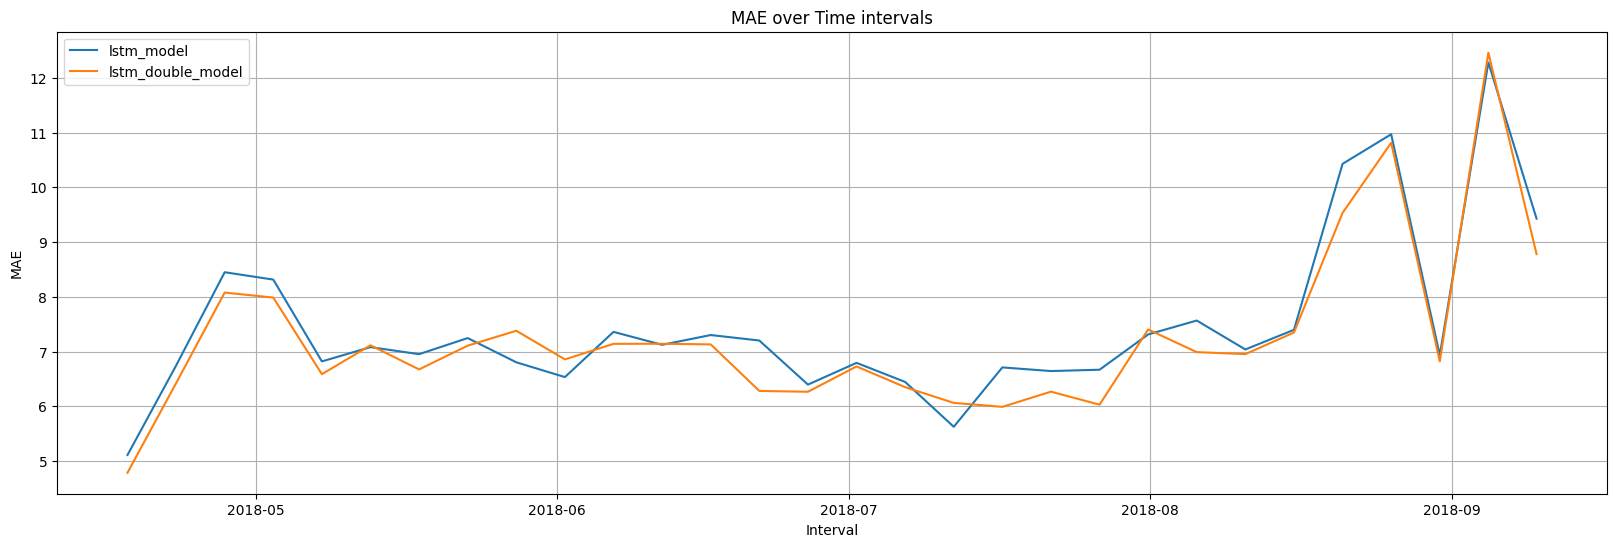

[{'lstm_model': {'min': 5.109490663740371,
   'max': 12.282663119506832,
   'mean': 7.45592207410052,
   'std': 1.4911061936781647}},
 {'lstm_double_model': {'min': 4.78591812854343,
   'max': 12.460151942443847,
   'mean': 7.249238164058405,
   'std': 1.4746749874942242}}]

In [7]:
compare_model_performance(test=test, seq_length=seq_length, future_steps=seq_length, models=[('lstm_model', lstm_model), ('lstm_double_model', lstm_double_model)], scaler_x=scaler_x, scaler_y=scaler_y)

In [8]:
# Define model
gru_model = Sequential()
gru_model.add(GRU(units=50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8850      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8901 (34.77 KB)
Trainable params: 8901 (34.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


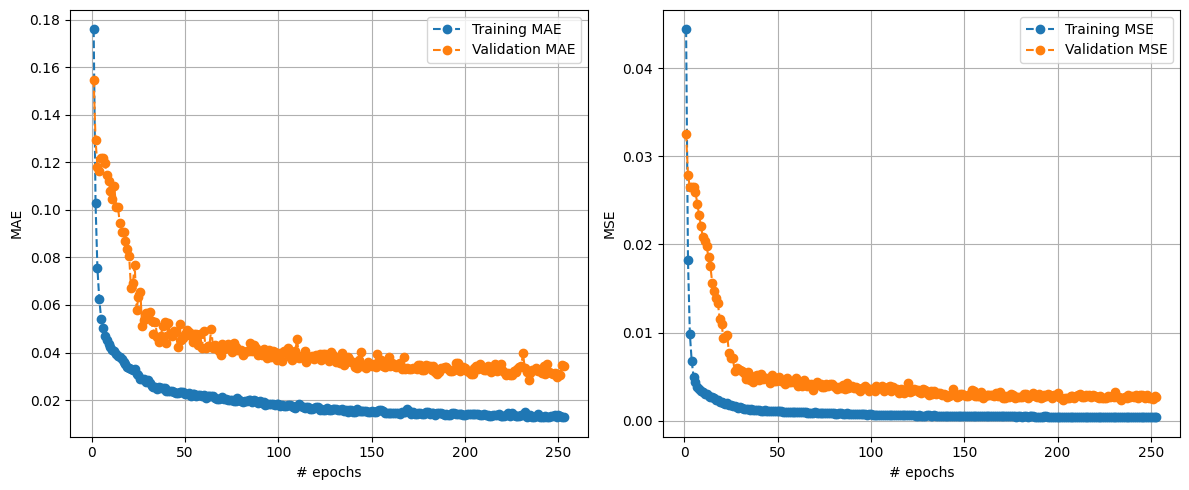

36/36 [==============================] - 3s 80ms/step - loss: 3.7587e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0026 - val_mean_absolute_error: 0.0343


In [9]:
for i in range(len(train_datasets)):
  gru_model.fit(
      X_trains[i],
      y_trains[i],
      epochs=300,
      batch_size=72,
      validation_data=(X_vals[i], y_vals[i]),
      callbacks=[
          PlotLearning(),
          EarlyStopping(monitor='val_loss', patience=50)
      ]
  )

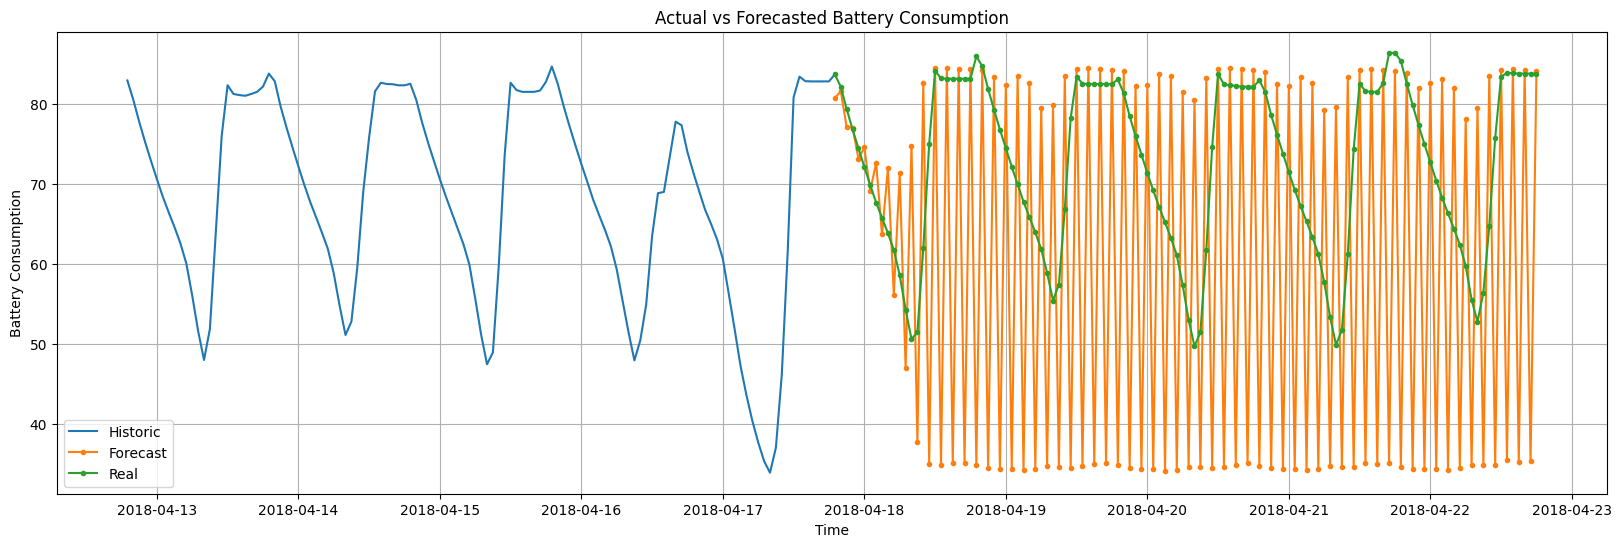

RMSE:  28.039824920431872
MSE:   786.2317815684723
MAE:   21.8957114054362


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [10]:
forecast_battery_consumption(test=test, seq_length=seq_length, forecast_steps=seq_length, future_steps=1, model=gru_model, scaler_x=scaler_x, scaler_y=scaler_y)

In [11]:
# Define model
gru_double_model = Sequential()
gru_double_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
gru_double_model.add(GRU(units=50))
gru_double_model.add(Dense(1, activation='sigmoid'))
gru_double_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
gru_double_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 120, 50)           8850      
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 24201 (94.54 KB)
Trainable params: 24201 (94.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


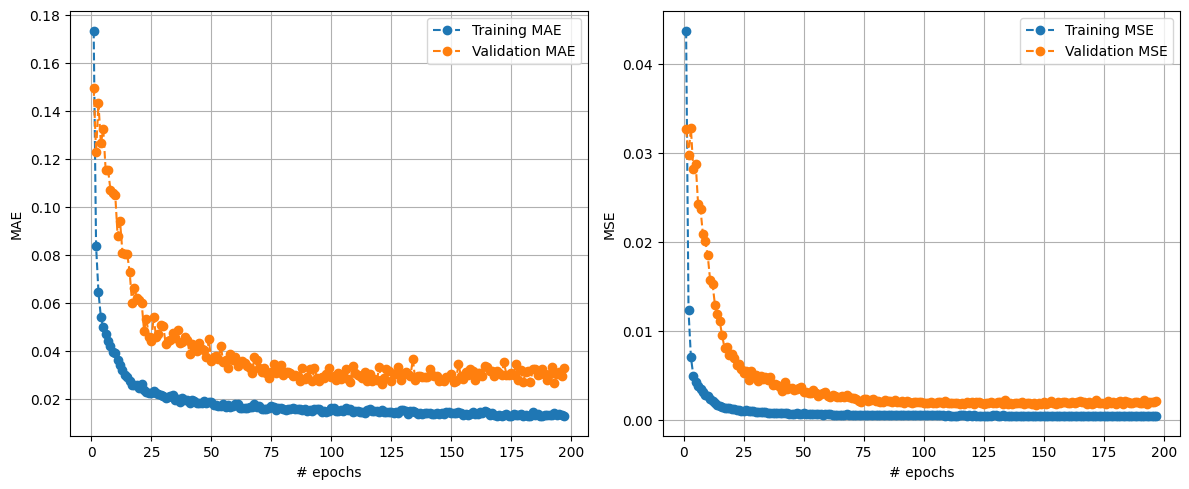

36/36 [==============================] - 7s 192ms/step - loss: 3.7956e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0021 - val_mean_absolute_error: 0.0329


In [12]:
for i in range(len(train_datasets)):
  gru_double_model.fit(
      X_trains[i],
      y_trains[i],
      epochs=300,
      batch_size=72,
      validation_data=(X_vals[i], y_vals[i]),
      callbacks=[
          PlotLearning(),
          EarlyStopping(monitor='val_loss', patience=50)
      ]
  )

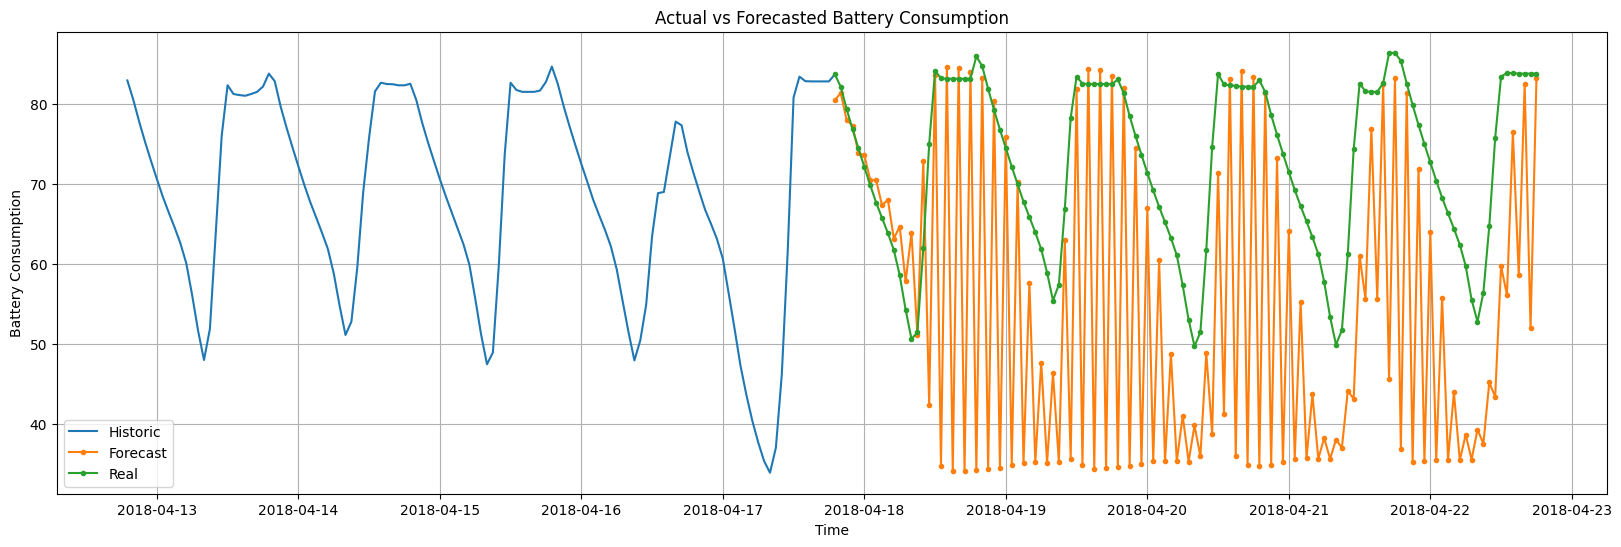

RMSE:  25.262462386272475
MSE:   638.1920058178315
MAE:   18.996031077490912


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [13]:
forecast_battery_consumption(test=test, seq_length=seq_length, forecast_steps=seq_length, future_steps=1, model=gru_double_model, scaler_x=scaler_x, scaler_y=scaler_y)

30/31 intervals ===>  119/120 steps


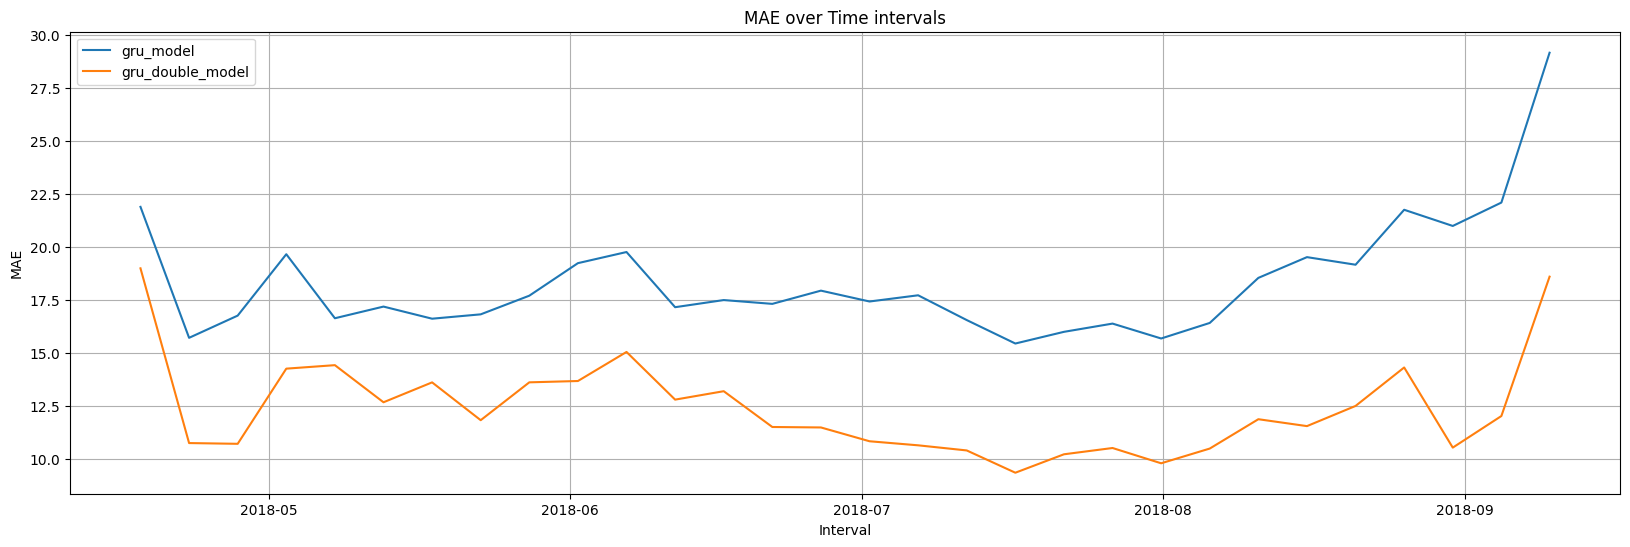

[{'gru_model': {'min': 15.447948571268716,
   'max': 29.16872902428336,
   'mean': 18.361782330736634,
   'std': 2.7372452274172954}},
 {'gru_double_model': {'min': 9.352118939887154,
   'max': 18.996031077490912,
   'mean': 12.40997942110325,
   'std': 2.2754966972199493}}]

In [14]:
compare_model_performance(test=test, seq_length=seq_length, future_steps=seq_length, models=[('gru_model', gru_model), ('gru_double_model', gru_double_model)], scaler_x=scaler_x, scaler_y=scaler_y)

30/31 intervals ===>  119/120 steps


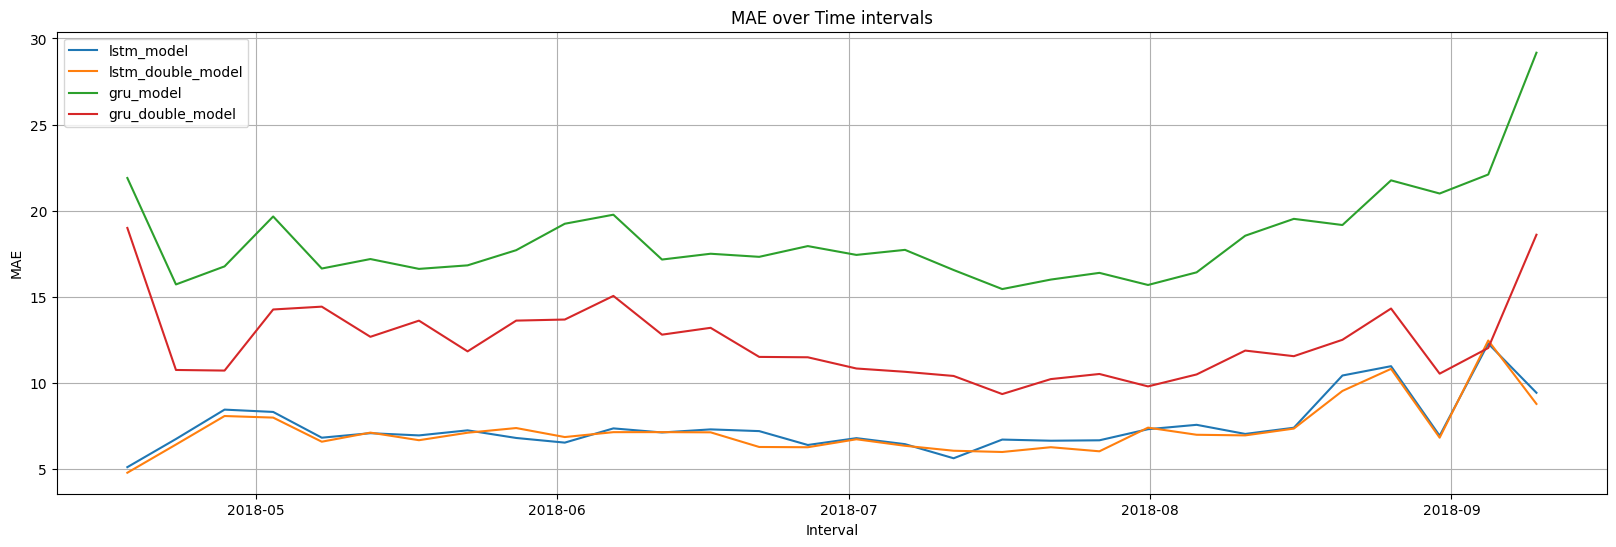

[{'lstm_model': {'min': 5.109490663740371,
   'max': 12.282663119506832,
   'mean': 7.45592207410052,
   'std': 1.4911061936781647}},
 {'lstm_double_model': {'min': 4.78591812854343,
   'max': 12.460151942443847,
   'mean': 7.249238164058405,
   'std': 1.4746749874942242}},
 {'gru_model': {'min': 15.447948571268716,
   'max': 29.16872902428336,
   'mean': 18.361782330736634,
   'std': 2.7372452274172954}},
 {'gru_double_model': {'min': 9.352118939887154,
   'max': 18.996031077490912,
   'mean': 12.40997942110325,
   'std': 2.2754966972199493}}]

In [15]:
compare_model_performance(test=test, seq_length=seq_length, future_steps=seq_length, models=[('lstm_model', lstm_model), ('lstm_double_model', lstm_double_model), ('gru_model', gru_model), ('gru_double_model', gru_double_model)], scaler_x=scaler_x, scaler_y=scaler_y)